### Import libraries

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

from util import get_root_path, preprocess_conversation, clean_turn

### Paths

In [8]:
CSV_DATASET_PATH = os.path.join(get_root_path(), "dataset", "merged_conversation.csv")
JSON_INFERENCE_PATH = os.path.join(get_root_path(), "dataset", "inference_test_binary.json")

### Functions

In [9]:
def load_and_split_dataset(remove_stopwords=False, lemmatize=False):
    """
    Load the dataset, preprocess the conversations, and split into training and test sets.

    Args:
        remove_stopwords (bool): Whether to remove stopwords.
        lemmatize (bool): Whether to lemmatize the text.

    Returns:
        tuple: A tuple containing the training and test sets (X_train, X_test, y_train, y_test) and the list of labels.
    """

    df = pd.read_csv(CSV_DATASET_PATH)
    df['cleaned'] = df['conversation'].apply(
        lambda x: preprocess_conversation(x, remove_stopwords=remove_stopwords, lemmatize=lemmatize)
    )

    X = df['cleaned']
    y = df['toxic']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test, df['toxic'].unique().tolist()

In [10]:
def model_test(model, X_test, y_test, labels):
    """
    Evaluate the model on the test set and print the classification report and confusion matrix.

    Args:
        model: The trained model to evaluate.
        X_test: The test features.
        y_test: The true labels for the test set.
        labels: The list of class labels.
    """

    print("\n[INFO] Best parameters found:")
    for param, value in model.best_params_.items():
        print(f"   {param}: {value}")
    print("\n[INFO] Best score achieved:")
    print(f"   {model.best_score_:.4f}")

    y_pred = model.predict(X_test)
    print("\n[INFO] Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels, digits=4))

    print("\n[INFO] Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

In [11]:
def preprocess_inference_data(remove_stopwords=False, lemmatize=False):
    """
    Preprocess the inference data from the JSON file.

    Args:
        remove_stopwords (bool): Whether to remove stopwords.
        lemmatize (bool): Whether to lemmatize the text.

    Returns:
        tuple: A tuple containing the preprocessed texts and their corresponding labels.
    """

    inference_texts = []
    inference_labels = []
    
    with open(JSON_INFERENCE_PATH, "r") as file:
        conversations = json.load(file)
        for conversation in conversations:
            cleaned_turns = [clean_turn(turn['text'], remove_stopwords=remove_stopwords, lemmatize=lemmatize) for turn in conversation['conversation']]
            conversation_text = ' [SEP] '.join(cleaned_turns)
            inference_texts.append(conversation_text)
            inference_labels.append(conversation['toxic'])

    return inference_texts, inference_labels

---------------------

# 1. Bag of Words

### 1.1 Logistic Regression

Fitting 5 folds for each of 180 candidates, totalling 900 fits

[INFO] Best parameters found:
   classifier__C: 100
   classifier__penalty: l2
   classifier__solver: liblinear
   vectorizer__min_df: 2
   vectorizer__ngram_range: (1, 2)

[INFO] Best score achieved:
   0.9962

[INFO] Classification Report:
              precision    recall  f1-score   support

          Si     0.9950    1.0000    0.9975       200
          No     1.0000    0.9950    0.9975       200

    accuracy                         0.9975       400
   macro avg     0.9975    0.9975    0.9975       400
weighted avg     0.9975    0.9975    0.9975       400


[INFO] Confusion Matrix:


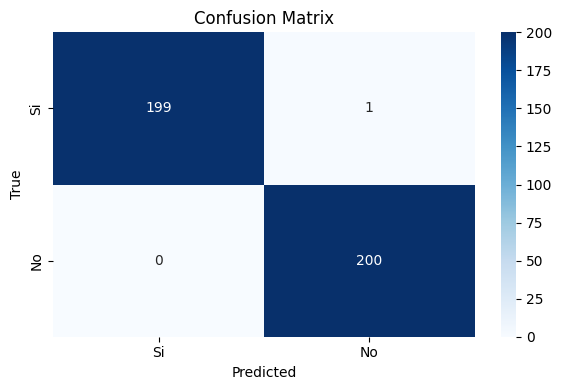


[INFO] Inference Predictions:
   Text: marco sono sicura di averti detto che oggi avevo quella visita medica importante [SEP] ma quando mai non me l hai mai detto te lo sei inventata adesso perchã sei arrabbiata che sono uscito [SEP] no te l ho scritto anche in un messaggio ieri sera guarda ti faccio vedere [SEP] smettila di essere cosã drammatica per ogni cosa sei sempre esagerata ovviamente non l ho visto stavo lavorando per noi [SEP] ma ero convinta forse forse mi sono sbagliata
   True Label: Si
   Predicted Label: Si

   Text: uff oggi al lavoro ã stata una giornata terribile ho fatto un errore in una presentazione importante [SEP] mi dispiace tanto che ti senta cosã capita a tutti di sbagliare non definisce il tuo valore sei bravissima nel tuo lavoro [SEP] lo so ma mi sento una stupida il mio capo non era per niente contento [SEP] vedrai che domani andrã meglio vuoi che ne parliamo o preferisci distrarti con un film sono qui per te qualsiasi cosa tu scelga [SEP] grazie solo sent

In [12]:
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
X_train, X_test, y_train, y_test, labels = load_and_split_dataset(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['saga', 'liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)


# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")
inference_predictions = grid_search.predict(inference_texts)
for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
    print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
    if true_label == pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")

### 1.2 Support Vector Machine

Fitting 5 folds for each of 90 candidates, totalling 450 fits

[INFO] Best parameters found:
   classifier__C: 0.1
   classifier__penalty: l2
   vectorizer__min_df: 2
   vectorizer__ngram_range: (1, 2)

[INFO] Best score achieved:
   0.9981

[INFO] Classification Report:
              precision    recall  f1-score   support

          Si     0.9950    1.0000    0.9975       200
          No     1.0000    0.9950    0.9975       200

    accuracy                         0.9975       400
   macro avg     0.9975    0.9975    0.9975       400
weighted avg     0.9975    0.9975    0.9975       400


[INFO] Confusion Matrix:


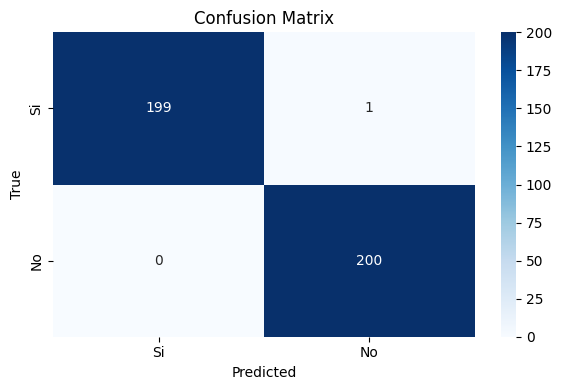


[INFO] Inference Predictions:
   Text: marco sono sicura di averti detto che oggi avevo quella visita medica importante [SEP] ma quando mai non me l hai mai detto te lo sei inventata adesso perchã sei arrabbiata che sono uscito [SEP] no te l ho scritto anche in un messaggio ieri sera guarda ti faccio vedere [SEP] smettila di essere cosã drammatica per ogni cosa sei sempre esagerata ovviamente non l ho visto stavo lavorando per noi [SEP] ma ero convinta forse forse mi sono sbagliata
   True Label: Si
   Predicted Label: Si

   Text: uff oggi al lavoro ã stata una giornata terribile ho fatto un errore in una presentazione importante [SEP] mi dispiace tanto che ti senta cosã capita a tutti di sbagliare non definisce il tuo valore sei bravissima nel tuo lavoro [SEP] lo so ma mi sento una stupida il mio capo non era per niente contento [SEP] vedrai che domani andrã meglio vuoi che ne parliamo o preferisci distrarti con un film sono qui per te qualsiasi cosa tu scelga [SEP] grazie solo sent

In [7]:
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
X_train, X_test, y_train, y_test, labels = load_and_split_dataset(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")
inference_predictions = grid_search.predict(inference_texts)
for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
    print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
    if true_label == pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")

### 1.3 Multinomial Naive Bayes

Fitting 5 folds for each of 90 candidates, totalling 450 fits

[INFO] Best parameters found:
   classifier__alpha: 0.01
   classifier__fit_prior: True
   vectorizer__min_df: 2
   vectorizer__ngram_range: (1, 2)

[INFO] Best score achieved:
   1.0000

[INFO] Classification Report:
              precision    recall  f1-score   support

          Si     1.0000    1.0000    1.0000       200
          No     1.0000    1.0000    1.0000       200

    accuracy                         1.0000       400
   macro avg     1.0000    1.0000    1.0000       400
weighted avg     1.0000    1.0000    1.0000       400


[INFO] Confusion Matrix:


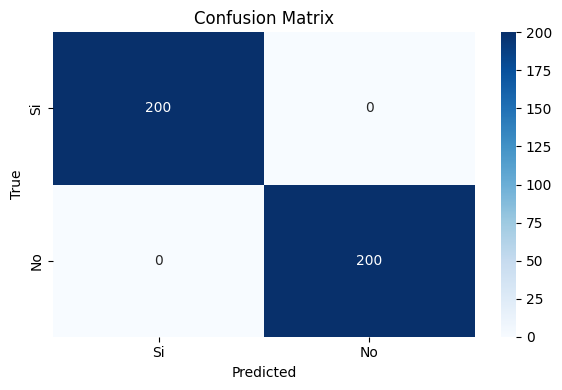


[INFO] Inference Predictions:
   Text: marco sono sicura di averti detto che oggi avevo quella visita medica importante [SEP] ma quando mai non me l hai mai detto te lo sei inventata adesso perchã sei arrabbiata che sono uscito [SEP] no te l ho scritto anche in un messaggio ieri sera guarda ti faccio vedere [SEP] smettila di essere cosã drammatica per ogni cosa sei sempre esagerata ovviamente non l ho visto stavo lavorando per noi [SEP] ma ero convinta forse forse mi sono sbagliata
   True Label: Si
   Predicted Label: Si

   Text: uff oggi al lavoro ã stata una giornata terribile ho fatto un errore in una presentazione importante [SEP] mi dispiace tanto che ti senta cosã capita a tutti di sbagliare non definisce il tuo valore sei bravissima nel tuo lavoro [SEP] lo so ma mi sento una stupida il mio capo non era per niente contento [SEP] vedrai che domani andrã meglio vuoi che ne parliamo o preferisci distrarti con un film sono qui per te qualsiasi cosa tu scelga [SEP] grazie solo sent

In [8]:
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
X_train, X_test, y_train, y_test, labels = load_and_split_dataset(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

param_grid = {
    'classifier__alpha': [0.01, 0.1, 1, 10, 100],
    'classifier__fit_prior': [True, False],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")
inference_predictions = grid_search.predict(inference_texts)
for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
    print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
    if true_label == pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")

---------------------

# 2. TF-IDF

### 2.1 Logistic Regression

Fitting 5 folds for each of 180 candidates, totalling 900 fits

[INFO] Best parameters found:
   classifier__C: 10
   classifier__penalty: l2
   classifier__solver: saga
   vectorizer__min_df: 5
   vectorizer__ngram_range: (1, 3)

[INFO] Best score achieved:
   0.9987

[INFO] Classification Report:
              precision    recall  f1-score   support

          Si     0.9950    1.0000    0.9975       200
          No     1.0000    0.9950    0.9975       200

    accuracy                         0.9975       400
   macro avg     0.9975    0.9975    0.9975       400
weighted avg     0.9975    0.9975    0.9975       400


[INFO] Confusion Matrix:


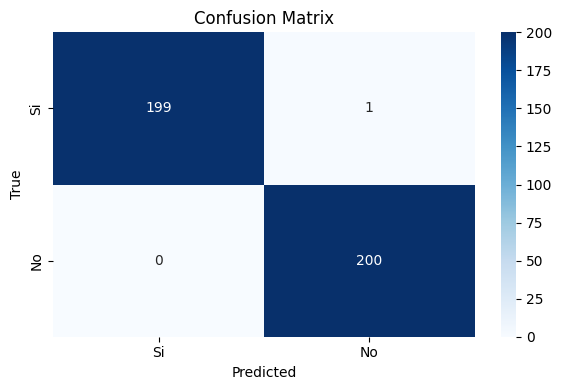


[INFO] Inference Predictions:
   Text: marco sono sicura di averti detto che oggi avevo quella visita medica importante [SEP] ma quando mai non me l hai mai detto te lo sei inventata adesso perchã sei arrabbiata che sono uscito [SEP] no te l ho scritto anche in un messaggio ieri sera guarda ti faccio vedere [SEP] smettila di essere cosã drammatica per ogni cosa sei sempre esagerata ovviamente non l ho visto stavo lavorando per noi [SEP] ma ero convinta forse forse mi sono sbagliata
   True Label: Si
   Predicted Label: Si

   Text: uff oggi al lavoro ã stata una giornata terribile ho fatto un errore in una presentazione importante [SEP] mi dispiace tanto che ti senta cosã capita a tutti di sbagliare non definisce il tuo valore sei bravissima nel tuo lavoro [SEP] lo so ma mi sento una stupida il mio capo non era per niente contento [SEP] vedrai che domani andrã meglio vuoi che ne parliamo o preferisci distrarti con un film sono qui per te qualsiasi cosa tu scelga [SEP] grazie solo sent

In [9]:
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
X_train, X_test, y_train, y_test, labels = load_and_split_dataset(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['saga', 'liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")
inference_predictions = grid_search.predict(inference_texts)
for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
    print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
    if true_label == pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")


### 2.2 Support Vector Machine

Fitting 5 folds for each of 90 candidates, totalling 450 fits

[INFO] Best parameters found:
   classifier__C: 1
   classifier__penalty: l2
   vectorizer__min_df: 2
   vectorizer__ngram_range: (1, 3)

[INFO] Best score achieved:
   0.9987

[INFO] Classification Report:
              precision    recall  f1-score   support

          Si     0.9950    1.0000    0.9975       200
          No     1.0000    0.9950    0.9975       200

    accuracy                         0.9975       400
   macro avg     0.9975    0.9975    0.9975       400
weighted avg     0.9975    0.9975    0.9975       400


[INFO] Confusion Matrix:


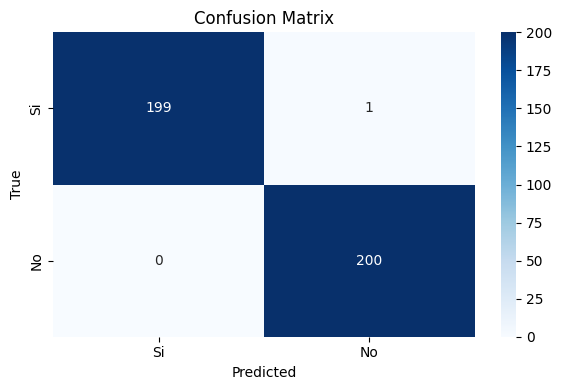


[INFO] Inference Predictions:
   Text: marco sono sicura di averti detto che oggi avevo quella visita medica importante [SEP] ma quando mai non me l hai mai detto te lo sei inventata adesso perchã sei arrabbiata che sono uscito [SEP] no te l ho scritto anche in un messaggio ieri sera guarda ti faccio vedere [SEP] smettila di essere cosã drammatica per ogni cosa sei sempre esagerata ovviamente non l ho visto stavo lavorando per noi [SEP] ma ero convinta forse forse mi sono sbagliata
   True Label: Si
   Predicted Label: Si

   Text: uff oggi al lavoro ã stata una giornata terribile ho fatto un errore in una presentazione importante [SEP] mi dispiace tanto che ti senta cosã capita a tutti di sbagliare non definisce il tuo valore sei bravissima nel tuo lavoro [SEP] lo so ma mi sento una stupida il mio capo non era per niente contento [SEP] vedrai che domani andrã meglio vuoi che ne parliamo o preferisci distrarti con un film sono qui per te qualsiasi cosa tu scelga [SEP] grazie solo sent

In [10]:
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
X_train, X_test, y_train, y_test, labels = load_and_split_dataset(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")
inference_predictions = grid_search.predict(inference_texts)
for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
    print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
    if true_label == pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")

### 2.3 Multinomial Naive Bayes

Fitting 5 folds for each of 90 candidates, totalling 450 fits

[INFO] Best parameters found:
   classifier__alpha: 0.01
   classifier__fit_prior: True
   vectorizer__min_df: 2
   vectorizer__ngram_range: (1, 3)

[INFO] Best score achieved:
   1.0000

[INFO] Classification Report:
              precision    recall  f1-score   support

          Si     1.0000    1.0000    1.0000       200
          No     1.0000    1.0000    1.0000       200

    accuracy                         1.0000       400
   macro avg     1.0000    1.0000    1.0000       400
weighted avg     1.0000    1.0000    1.0000       400


[INFO] Confusion Matrix:


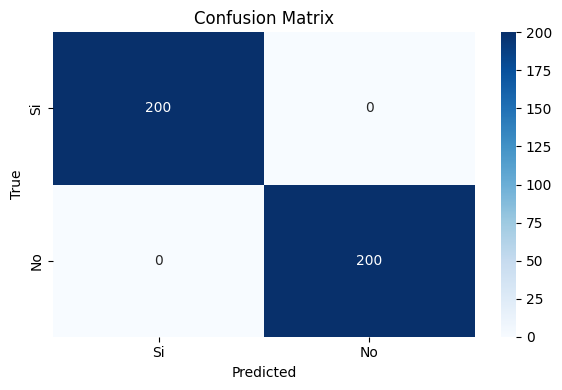


[INFO] Inference Predictions:
   Text: marco sono sicura di averti detto che oggi avevo quella visita medica importante [SEP] ma quando mai non me l hai mai detto te lo sei inventata adesso perchã sei arrabbiata che sono uscito [SEP] no te l ho scritto anche in un messaggio ieri sera guarda ti faccio vedere [SEP] smettila di essere cosã drammatica per ogni cosa sei sempre esagerata ovviamente non l ho visto stavo lavorando per noi [SEP] ma ero convinta forse forse mi sono sbagliata
   True Label: Si
   Predicted Label: Si

   Text: uff oggi al lavoro ã stata una giornata terribile ho fatto un errore in una presentazione importante [SEP] mi dispiace tanto che ti senta cosã capita a tutti di sbagliare non definisce il tuo valore sei bravissima nel tuo lavoro [SEP] lo so ma mi sento una stupida il mio capo non era per niente contento [SEP] vedrai che domani andrã meglio vuoi che ne parliamo o preferisci distrarti con un film sono qui per te qualsiasi cosa tu scelga [SEP] grazie solo sent

In [11]:
REMOVE_STOPWORDS = False
LEMMATIZE = False


# ---- 1. Load and preprocess the dataset ----
X_train, X_test, y_train, y_test, labels = load_and_split_dataset(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)


# ---- 2. Define the pipeline and hyperparameter grid ----
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

param_grid = {
    'classifier__alpha': [0.01, 0.1, 1, 10, 100],
    'classifier__fit_prior': [True, False],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__min_df': [1, 2, 5],
}


# ---- 3. Perform grid search with cross-validation ----
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)


# ---- 4. Test and output the results ----
model_test(grid_search, X_test, y_test, labels)

# ---- 5. Inference on new data ----
inference_texts, inference_labels = preprocess_inference_data(remove_stopwords=REMOVE_STOPWORDS, lemmatize=LEMMATIZE)
        
accuracy = 0
print("\n[INFO] Inference Predictions:")
inference_predictions = grid_search.predict(inference_texts)
for text, true_label, pred_label in zip(inference_texts, inference_labels, inference_predictions):
    print(f"   Text: {text}\n   True Label: {true_label}\n   Predicted Label: {pred_label}\n")
    if true_label == pred_label:
        accuracy += 1
print(f"[INFO] Inference Accuracy: {accuracy}/{len(inference_texts)} ({(accuracy / len(inference_texts)) * 100:.2f}%)")